# MSP projekt 2 - Ondřej Lukášek (xlukas15)

Začnu tím, že si naimportuji potřebné knihovny, se kterými budu v projektu pracovat.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import scipy.special as special
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Úkol 1 - Věrohodnost

Nejprve si načtu list (sheet), který obsahuje data, se kterými budu pracovat.

Předpřipravím si parametry tak, abych je mohl rovnou použít dál.

In [3]:
file_path = 'Data_2024.xlsx'
sheet_name = 'Data_věrohodnost'

data = pd.read_excel(file_path, sheet_name=sheet_name)
times = data['doba práce v oboru [roky]'].dropna().to_numpy()
censored = data['censored'].to_numpy()

initial_params = (1.5, 5.0)

### Bod 1

In [4]:
def weibull_log_likelihood(params, times, censored):
    k, lam = params
    
    # logaritmizace pro necenzurovana data
    log_f = np.log(k) - k * np.log(lam) + (k - 1) * np.log(times) - (times / lam)**k
    # logaritmizace pro cenzurovana data
    log_sf = - (times / lam)**k
    
    # spojeni logaritmu pro necenzurovana a cenzurovana data
    likelihood = (1 - censored) * log_f + censored * log_sf

    return likelihood.sum()


# MOZNA SMAZAT???
def weibull_log_likelihood_derivatives(params, times, censored):
    k, lam = params

    # predvypocitani konstant, co se budou v derivacich opakovat
    t_lam_k = (times / lam)**k
    log_t_lam = np.log(times / lam)
    
    # parcialni derivace logaritmu podle parametru k
    dL_dk = np.sum((1 - censored) * (1 / k + log_t_lam - t_lam_k * log_t_lam) + censored * (-t_lam_k * log_t_lam))
    # parcialni derivace logaritmu podle parametru lambda
    dL_dlam = np.sum((1 - censored) * (-k / lam + k * t_lam_k / lam) + censored * (k * t_lam_k / lam))
    
    return np.array([dL_dk, dL_dlam])


log_likelihood = weibull_log_likelihood(initial_params, times, censored)
derivatives = weibull_log_likelihood_derivatives(initial_params, times, censored)

print(f'Log-likelihood: {log_likelihood}')
print(f'Derivatives: {derivatives}')

Log-likelihood: -740.8976732574417
Derivatives: [64.24195393 77.00791218]


### Bod 2

In [5]:
def neg_weibull_log_likelihood(params, times, censored):
    return -weibull_log_likelihood(params, times, censored)

result = opt.minimize(
    fun=neg_weibull_log_likelihood,
    x0=initial_params,
    args=(times, censored),
    method='L-BFGS-B',
    bounds=[(0.1, None), (0.1, None)]
)

optimal_shape, optimal_scale = result.x

print('Maximal likelihood estimation:')
print(f'Shape (k): {optimal_shape}')
print(f'Scale (lambda): {optimal_scale}')

Maximal likelihood estimation:
Shape (k): 6.172808847674017
Scale (lambda): 7.4294603426242265


### Bod 3

Pomocí věrohodnostního poměru otestujte hypotézu, že exponenciální rozdělení je postačujícím modelem zapsaných dat (Parametr tvaru = 1).

By default je distribuční funkce (pro $ x \geq 0 $) exponenciálního rozdělení:

$ f(x; \lambda) = \lambda e^{-\lambda x} $

Logaritmus potom bude:

$ \ell(x; \lambda) = \ln \lambda - \lambda x $

Log-likelihood potom je:

$ \ell(\lambda) = \sum_{i=1}^n \left[ \ln \lambda - \lambda x_i \right]  $

In [6]:
def exponential_log_likelihood(lam, times, censored):
    log_f = np.log(lam) - lam * times
    log_sf = -lam * times

    likelihood = (1 - censored) * log_f + censored * log_sf
    return np.sum(likelihood)


result_exp = opt.minimize(
    fun=lambda lam: -exponential_log_likelihood(lam[0], times, censored),
    x0=[1.0],
    bounds=[(0.1, None)],
    method='L-BFGS-B'
)

lambda_exp = result_exp.x[0]
log_likelihood_exp = -result_exp.fun

k_weibull, lambda_weibull = result.x
result_weibull = -result.fun

# VYPOCET VEROHODNOSTNIHO POMERU
LR = 2 * (result_weibull - log_likelihood_exp)

alpha = 0.05
critical_value = stats.chi2.ppf(1 - alpha, df=1)

print(f'Likelihood ratio: {LR}')
print(f'Critical value (alpha = {alpha}): {critical_value}')

if LR > critical_value:
    print('Zamítáme nulovou hypotézu. Exponenciální rozdělení není postačující.')
else:
    print('Nulovou hypotézu nezamítáme. Exponenciální rozdělení je postačující.')

Likelihood ratio: 592.3898153427439
Critical value (alpha = 0.05): 3.841458820694124
Zamítáme nulovou hypotézu. Exponenciální rozdělení není postačující.


### Bod 4

Podle výsledku z předchozího bodu použijte výsledné rozdělení pravděpodobnosti (s maximálně věrohodnými odhady jako parametry) a nalezněte bodové odhady pro střední dobu zaměstnání v oboru a 10% percentil zaměstnání v oboru (za jakou dobu odejde do jiného oboru 10% absolventů).

Jelikož v předchozím bodu na základě testu vyšlo, že exponenciální rozdělení není postačující, budu dále pokračovat s Weibullovým rozdělením.

U Weibullova rozdělení se střední hodnota vypočítá následovně (z Wikipedie):

$ Mean = \lambda \Gamma (1 + \frac{1}{k}) $

A kvantily se počítají pomocí vzorce:

$ Q(p) = \lambda (- \ln (1 - p))^{\frac{1}{k}} \implies Q(0.1) = \lambda (- \ln (0.9))^{\frac{1}{k}} $

In [7]:
def weibull_mean(k, lam):
    return lam * special.gamma(1 + 1 / k)


def weibull_quantile(p, k, lam):
    return lam * (- np.log(1 - p))**(1 / k)


mean = weibull_mean(k_weibull, lambda_weibull)
quantile = weibull_quantile(0.1, k_weibull, lambda_weibull)

print('=== Weibull distribution ===')
print(f'Shape (k): {k_weibull}')
print(f'Scale (lambda): {lambda_weibull}\n')

print('=== Mean, Quantile ===')
print(f'Mean: {mean}')
print(f'10% quantile: {quantile}')

=== Weibull distribution ===
Shape (k): 6.172808847674017
Scale (lambda): 7.4294603426242265

=== Mean, Quantile ===
Mean: 6.903242509050911
10% quantile: 5.159769490910647


### Bod 5 (dobrovolný)

Zkuste nějak slovně charakterizovat/popsat fungování doby zaměstnání v oboru jako náhodné veličiny, dle vašich výsledků a parametrů.

**TODO**

## Úkol 2 - Regrese

Opět začnu tím, že si nejprve načtu data z Excelu. Pro jistotu si přetypuji hodnoty, abych se vyhnul problémům do budoucna (kdy náhodou něco nefungovalo). 

In [8]:
file_path = 'Data_2024.xlsx'
sheet_name = 'Data_regrese'

df = pd.read_excel(file_path, sheet_name=sheet_name)

df['OSType'] = df['OSType'].astype('category')

columns_to_numeric = ['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'Ping [ms]']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

# prejmenoal jsem si sloupec Ping [ms] na Ping, protoze mi to delalo problemy u ols modelu
df.rename(columns={'Ping [ms]': 'Ping'}, inplace=True)

df.head()

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76


In [9]:
df['ActiveUsers'] = 2 * (df['ActiveUsers'] - (df['ActiveUsers'].max() + df['ActiveUsers'].min()) / 2) / (df['ActiveUsers'].max() - df['ActiveUsers'].min())

df.head()

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,-0.191837,0.8283,0.1717,47
1,iOS,0.509388,0.3461,0.6539,46
2,Windows,0.775918,0.2178,0.7822,55
3,Android,0.778980,0.0794,0.9206,56
4,MacOS,0.919592,0.7282,0.2718,76


In [10]:
# prevod na dummy promenne - Android dropneme, protoze bude refencni kategorii
dummy_ostype = pd.get_dummies(df['OSType'], drop_first=True)

# sloucime je s puvodnim dataframem a dropneme puvodni sloupec, protoze neni potreba
df = pd.concat([df, dummy_ostype], axis=1)
df = df.drop(columns=['OSType'])

print(df.head())

   ActiveUsers  InteractingPct  ScrollingPct  Ping  MacOS  Windows    iOS
0    -0.191837          0.8283        0.1717    47  False    False   True
1     0.509388          0.3461        0.6539    46  False    False   True
2     0.775918          0.2178        0.7822    55  False     True  False
3     0.778980          0.0794        0.9206    56  False    False  False
4     0.919592          0.7282        0.2718    76   True    False  False


### Bod 1

Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí "plný" model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).

- Zapište rovnici Vašeho finálního modelu.
- Diskutujte splnění přepokladů lineární regrese a základní regresní diagnostiky.
- Pokud (až během regresního modelování) identifikujete některé "nejodlehlejší" hodnoty, po alespoň krátkém zdůvodnění, vyřadit.

Začnu tím, že si data vizualizuji pro lepší představu toho, s čím budu vlastně pracovat.

Zřejmě budu pracovat se závislostí odezvy na počtu aktivní uživatelů na mé "socce".

Na grafu je možné si pouhým okem všimnout rostoucí tendence - tedy čím víc je uživatelů, tím větší je ping.


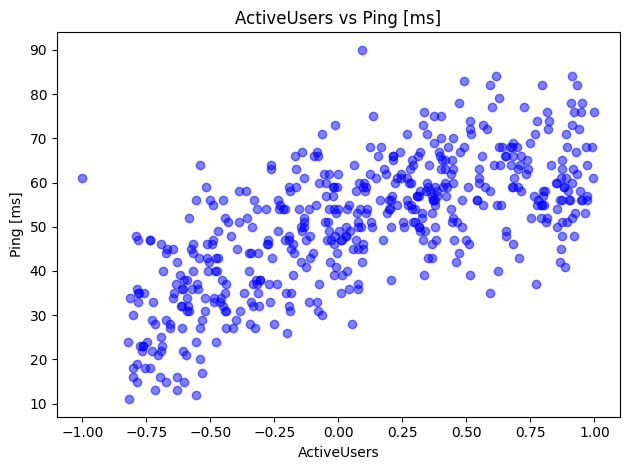

In [11]:
# ActiveUsers vs Ping [ms]
plt.scatter(df['ActiveUsers'], df['Ping'], alpha=0.5, color='blue')
plt.title('ActiveUsers vs Ping [ms]')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')


plt.tight_layout()
plt.show()

Teďka už můžu vytvořit formuli, která bude na začátku vypadat takto:

$   formule = 
    \beta_{0} +
    \beta_{1} \cdot ActiveUsers + \beta_{2} \cdot InteractingPct + \beta_{3} \cdot ScrollingPct + \beta_{4} \cdot MacOS + \beta_{5} \cdot Windows + \beta_{6} \cdot iOS +
    \beta_{7} \cdot ActiveUsers^2 + \beta_{8} \cdot ActiveUsers \cdot InteractingPct + \beta_{9} \cdot ActiveUsers \cdot ScrollingPct + \beta_{10} ActiveUsers \cdot MacOS + \beta_{11} \cdot ActiveUsers \cdot Windows + \beta_{12} ActiveUsers \cdot iOS +
    \beta_{13} \cdot InteractingPct^2 + \beta_{14} \cdot InteractingPct \cdot ScrollingPct + \beta_{15} \cdot InteractingPct \cdot MacOS + \beta_{16} \cdot InteractingPct \cdot Windows + \beta_{17} \cdot InteractingPct \cdot iOS +
    \beta_{18} \cdot ScrollingPct^2 + \beta_{19} \cdot ScrollingPct \cdot MacOS + \beta_{20} \cdot ScrollingPct \cdot Windows + \beta_{21} \cdot ScrollingPct \cdot iOS
$

In [12]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + ScrollingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:ScrollingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:ScrollingPct + InteractingPct:MacOS + InteractingPct:Windows + InteractingPct:iOS +'
    'I(ScrollingPct**2) + ScrollingPct:MacOS + ScrollingPct:Windows + ScrollingPct:iOS'
)

def evaluate_model(df, formula):
    model = smf.ols(formula=formula, data=df)
    result = model.fit()
    return result, model

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        18:56:28   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [13]:
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()

vif_df.columns = ['VIF']
print('====  VIF ====')
print(vif_df)

print('\n\n\n==== Matice korelace ====')
print(X.corr())


====  VIF ====
                                     VIF
Intercept                       0.000000
MacOS[T.True]                        inf
Windows[T.True]                      inf
iOS[T.True]                          inf
ActiveUsers                          inf
ActiveUsers:MacOS[T.True]       2.385958
ActiveUsers:Windows[T.True]     2.434729
ActiveUsers:iOS[T.True]         2.231460
InteractingPct                       inf
InteractingPct:MacOS[T.True]         inf
InteractingPct:Windows[T.True]       inf
InteractingPct:iOS[T.True]           inf
ScrollingPct                         inf
ScrollingPct:MacOS[T.True]           inf
ScrollingPct:Windows[T.True]         inf
ScrollingPct:iOS[T.True]             inf
I(ActiveUsers ** 2)             1.145080
ActiveUsers:InteractingPct           inf
ActiveUsers:ScrollingPct             inf
I(InteractingPct ** 2)               inf
InteractingPct:ScrollingPct          inf
I(ScrollingPct ** 2)                 inf



==== Matice korelace ====
             

C:\Users\ondre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\ondre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Na výsledku si lze všimnout, že některé hodnoty VIFu jsou > 10.

Vytvořím si ještě matici korelace, abych zjistil, kde se nacházejí závislosti, které mi tvoří problémy s vytvořením modelu.

Zjišťuji, že problém tvoří korelace mezi `ScrollingPct` a `InteractingPct`.
Dává to i smysl, vzhledem k tomu, že hodnoty si jsou doplňky, protože se jedná o procentuální hodnoty.
Zbavit se tedy nejspíš mohu jedné z nich a je jedno které. Zkusím se zbavit `InteractingPct` a výpočet VIFu provedu znovu.

In [14]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:MacOS + InteractingPct:Windows + InteractingPct:iOS'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        18:56:28   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Formuli jsem upravil tak, abych z ní vyškrtl `ScrollingPct`, teď zkusím znovu přepočítat VIFy.

In [15]:
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()

vif_df.columns = ['VIF']
print('====  VIF ====')
print(vif_df)

====  VIF ====
                                      VIF
Intercept                       23.383991
MacOS[T.True]                    6.272004
Windows[T.True]                  6.417808
iOS[T.True]                      5.723560
ActiveUsers                      7.817225
ActiveUsers:MacOS[T.True]        2.385958
ActiveUsers:Windows[T.True]      2.434729
ActiveUsers:iOS[T.True]          2.231460
InteractingPct                  20.191723
InteractingPct:MacOS[T.True]     7.586537
InteractingPct:Windows[T.True]   6.857633
InteractingPct:iOS[T.True]       6.028016
I(ActiveUsers ** 2)              1.145080
ActiveUsers:InteractingPct       3.872128
I(InteractingPct ** 2)          16.060875


Nyní už vycházejí všechny hodnoty VIFu < 10, což je přijatelné. Můžu se tedy přesunout k zpětné eliminaci.

To znamená, že teď budu potřebovat, aby všechny hodnoty ve sloupci P > |t| byly menší, než jaký je můj nastavený práh. Ten bude nastaven na klasických 5%, tedy 0.05.

Toho docílím tak, že postupně budu odstraňovat největší členy formule a sledovat, jak se model změní při postupných změnách.
V tuto chvíli je největší hodnota `InteractingPct:iOS[T.True]` s hodnotou `0.921`.
Smažu tedy tento člen.

In [16]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:MacOS + InteractingPct:Windows'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          3.58e-187
Time:                        18:56:28   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

První člen byl odstraněn, nicméně je potřeba pracovat dále. Nyní je největším členem `InteractingPct:Windows[T.True]` s hodnotou `0.902`.
Tak jej odstraníme a opět vyhodnotíme.

In [17]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:MacOS'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          2.38e-188
Time:                        18:56:28   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Stále jsou zde členy, které je potřeba zmenšit. Nyní to bude `InteractingPct:MacOS[T.True]` s hodnotou `0.760`.

In [18]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2)'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          1.57e-189
Time:                        18:56:28   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Opět vyhodnoceno, ale stále zbývá člen `I(InteractingPct ** 2)` s hodnotou `0.278`, který je potřeba odstranit.

In [19]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        18:56:28   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Poslední úprava mě dostala ke zdárnému výsledku. Žádný z členů formule mi nepřesahuje hodnotu `0.05`, přičemž největší z nich je `ActiveUsers:Windows[T.True]` s hodnotou `0.015`, což je v pořádku.

Finální formule tedy vypadá takto:

$ 
    formula = 
    \beta_{0} +
    \beta_{1} \cdot ActiveUsers + \beta_{2} \cdot InteractingPct + \beta_{3} \cdot MacOS + \beta_{4} \cdot Windows + \beta_{5} \cdot iOS +
    \beta_{6} \cdot ActiveUsers^2 + \beta_{7} \cdot ActiveUsers \cdot InteractingPct + \beta_{8} \cdot ActiveUsers \cdot MacOS + \beta_{9} \cdot ActiveUsers \cdot Windows + \beta_{10} \cdot ActiveUsers \cdot Windows
$

**Rovnice modelu**

Rovnice modelu tedy bude vypadat následovně:

$ 
    model = 
    40.2495 +
    24.4186 \cdot ActiveUsers + 18.3647 \cdot InteractingPct + 8.7999 \cdot MacOS + 4.1936 \cdot Windows - 5.3112 \cdot iOS -
    9.9907 \cdot ActiveUsers^2 - 15.1484 \cdot ActiveUsers \cdot InteractingPct + 6.9549 \cdot ActiveUsers \cdot MacOS - 3.6108 \cdot ActiveUsers \cdot Windows - 5.0588 \cdot ActiveUsers \cdot Windows
$

**Diskuze splnění předpokladů lineární regrese**

TODO

**Zbavení se odlehlých hodnot**

In [20]:
influence = result.get_influence()
# Leverage
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) jako n-tice polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizovaná rezidua
standardized_residuals = influence.resid_studentized_internal
# Studentizovaná rezidua
studentized_residuals = influence.resid_studentized_external
# Výpočet p-hodnot pro studentizovaná rezidua
studentized_residuals_pvalues = 2 * (1 - stats.t.cdf(np.abs(studentized_residuals), df=df.shape[0]-len(result.params)))

#tabulka dohromady dořešit změny počtu řádků
outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Studentized Residuals p-value': studentized_residuals_pvalues,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=df.index)
#vyber jen "zajímavý" hodnoty
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(result.params)/df.shape[0]) | (np.abs(outl_stats_df['Standardized Residuals']) > 2) | (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]

summary_frame = influence.summary_frame()

print(outl_stats_df)

     Leverage  Standardized Residuals  Studentized Residuals  \
62   0.012590               -2.036977              -2.043554   
82   0.010646                2.699228               2.716710   
114  0.012955                2.111260               2.118748   
129  0.014222               -2.141213              -2.149089   
145  0.023780               -2.292470              -2.302490   
178  0.047086                2.054883               2.061673   
254  0.011482                2.011917               2.018204   
255  0.009986                5.945469               6.165493   
310  0.016649               -2.111115              -2.118601   
332  0.030075                2.124928               2.132592   
428  0.028086                2.048785               2.055502   
430  0.017414               -2.080739              -2.087844   
476  0.074941                8.830417               9.618155   
490  0.026903               -2.230330              -2.239431   

     Studentized Residuals p-value  Coo

Podle leverage na první pohled nic nepoznám, nicméně jakmile se podívám na hodnoty reziduí, tak je vidět, že dvě hodnoty vybočují z nějakého standardu.
Konkrétně to jsou hodnoty na indexu `255` a `476`, nicméně protože vím, že ["S velkou mocí přichází velká zodpovědnost"](https://www.youtube.com/watch?v=guuYU74wU70&t=70s), zkusím si ještě vykreslit graf reziduí a predikovaných hodnot, který jsme si ukazovali na demo cviku.
V praxi by měla totiž všechna data "komíhat" okolo nuly a nic by nemělo být nějak moc vzdálené.

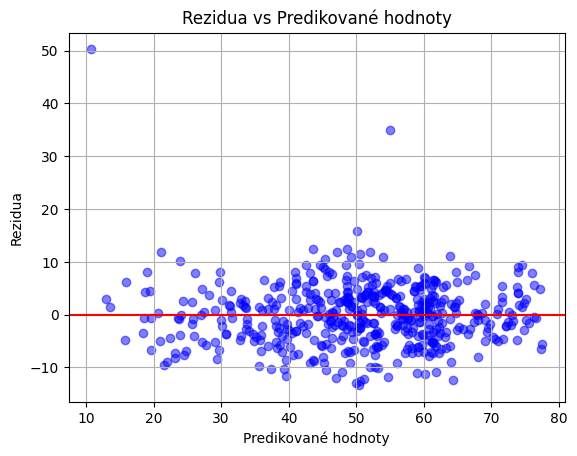

In [21]:
plt.scatter(result.fittedvalues, result.resid, alpha=0.5, color='blue')

plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

No a graf ukázal, že tato dvě data skutečně dělají problémy, můžu tedy přejít ke jejich smazání.

Nicméně ještě předtím bych ukázal, o která data se jedná na grafu, který jsem si vykresloval ještě ["před dávnými časy v předaleké galaxii"](https://youtu.be/iXDnFYu91vY?t=25) (asi o 10-15 buněk výš).

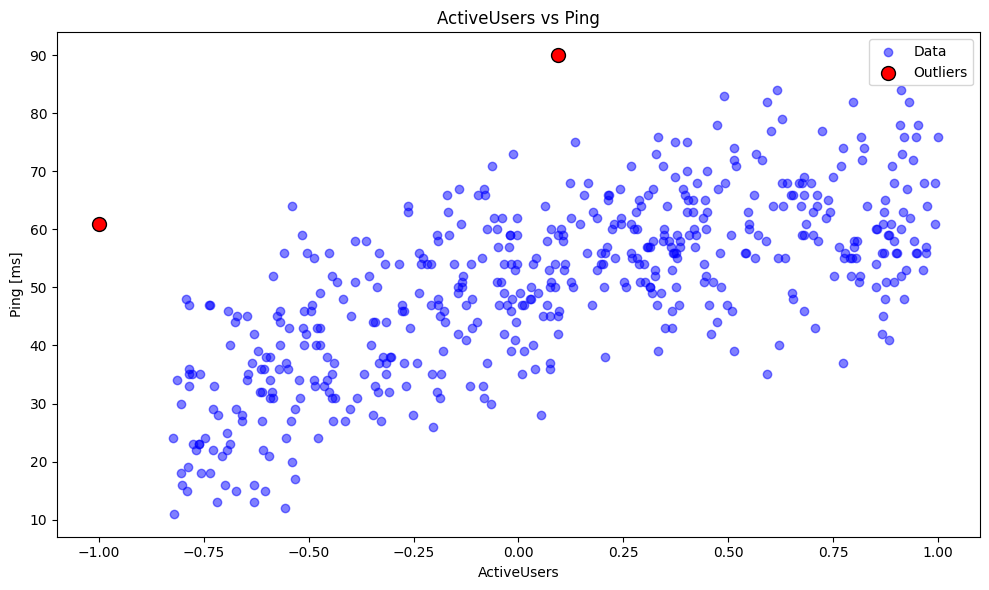

In [22]:
outliers = [255, 476]

plt.figure(figsize=(10, 6))
plt.scatter(df['ActiveUsers'], df['Ping'], alpha=0.5, color='blue', label='Data')

plt.scatter(
    df.loc[outliers, 'ActiveUsers'], 
    df.loc[outliers, 'Ping'], 
    color='red', 
    label='Outliers', 
    s=100,
    edgecolors='black'
)

plt.title('ActiveUsers vs Ping')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')
plt.legend()

plt.tight_layout()
plt.show()

No, teď tedy přejdu k smazání těchto outlierů.
Zase si také vykreslím grafy, jako předtím, čistě pro kontrolu, že jsem nikde neudělal chybu.

A zjevně nic špatně není.
Graf reziduí je nyní již opravdu okolo nuly a obecný graf dat už neobsahuje zvýrazněné outliery, jako výše.
Vše tedy zjevně funguje.

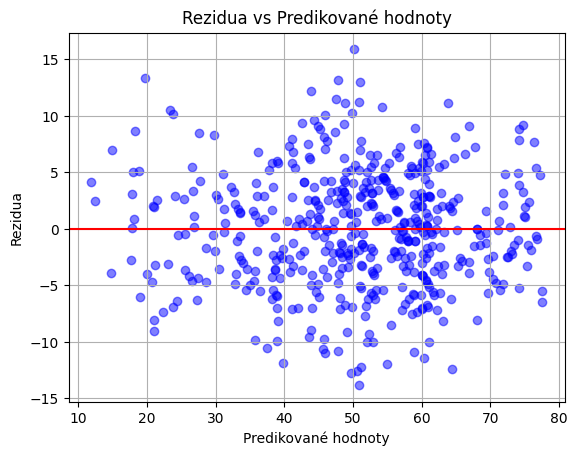

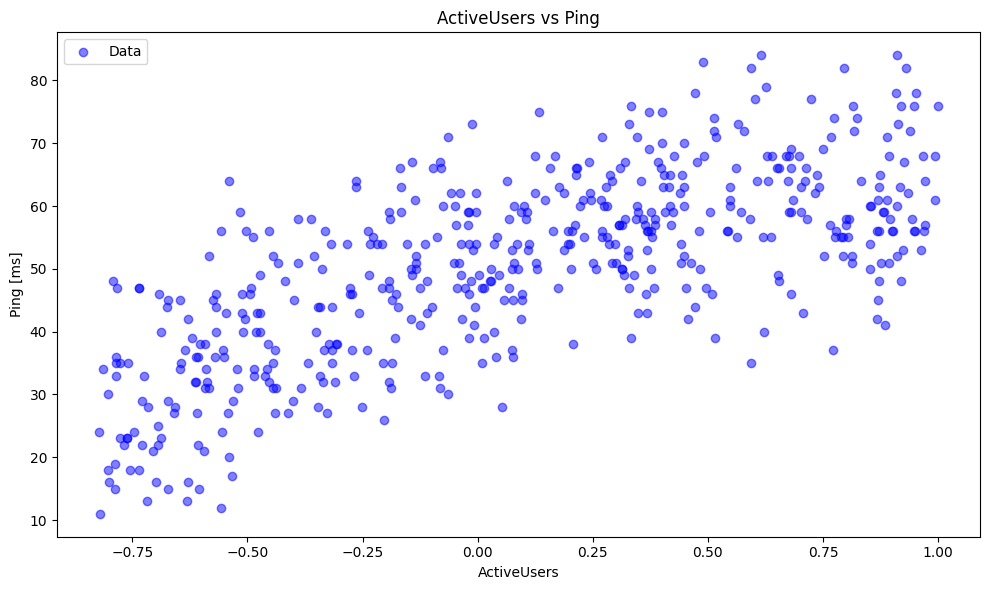

In [23]:
# vypustim outliery
df_final = df.drop(index=outliers)

# prepoctu model bez outlieru
result, model = evaluate_model(df_final, formula)

# GRAF REZIDUI VS PREDIKOVANE HODNOTY
plt.scatter(result.fittedvalues, result.resid, alpha=0.5, color='blue')

plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# GRAFIK DAT BEZ OUTLIERU
plt.figure(figsize=(10, 6))
plt.scatter(df_final['ActiveUsers'], df_final['Ping'], alpha=0.5, color='blue', label='Data')

plt.title('ActiveUsers vs Ping')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')
plt.legend()

plt.tight_layout()
plt.show()

### Bod 2

Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější (největší) hodnotu (použijte model, nikoli samotná pozorování).

In [36]:
# opisu si rovnici modelu z vysledku prvniho bodu
def model_equation(params):
    active_users, interacting_pct, macos, windows, ios = params
    
    return - (
        + 40.2495
        + 24.4186 * active_users
        + 18.3647 * interacting_pct
        + 8.7999 * macos
        + 4.1936 * windows
        - 5.3112 * ios
        - 9.9907 * active_users**2
        - 15.1484 * active_users * interacting_pct
        + 6.9549 * active_users * macos
        - 3.6108 * active_users * windows
        - 5.0588 * active_users * ios
    )

# nastavim si pocatecni hodnoty na stred intervalu (neni to teda prumer hodnot, ale tak aspon cca)
# pouzil jsem totiz preskalovani na interval <-1; 1>
intial_guess = [0, 0, 0, 0, 1]

# nastavim si hranice, ve kterych se parametry muzou pohybovat (podle zvoleneho skalovani)
# MacOS, Windows, iOS jsou dummy promenne, takze ty jsou bud 0 nebo 1 (delal jsem to na zacatku tohoto ukolu)
bounds = [
    (-1, 1), # ActiveUsers
    (-1, 1), # InteractingPct
    (0, 1), # MacOS
    (0, 1), # Windows
    (0, 1)  # iOS
]

# spustim optimalizaci (podobne jako v prvnim ukolu)
result2 = opt.minimize(model_equation, intial_guess, bounds=bounds)

# tady tohle mi da, jake jsou optimalni parametry
optimal_params = result2.x

# z tohodle zjistim, jaky je maximalni ping
max_ping = -result2.fun

# a nejak si to vypisu
print(f'Optimal parameters:')
print(f'\tActiveUsers: {round(optimal_params[0], 4)}')
print(f'\tInteractingPct: {round(optimal_params[1], 4)}')
print(f'\tMacOS: {round(optimal_params[2], 4)}')
print(f'\tWindows: {round(optimal_params[3], 4)}')
print(f'\tiOS: {round(optimal_params[4], 4)}')

print(f'\nMax ping: {max_ping}')

Optimal parameters:
	ActiveUsers: 0.6313 => denormalizovano: 8146.381647457891
	InteractingPct: 1.0
	MacOS: 1.0
	Windows: 1.0
	iOS: 0.0

Max ping: 75.5894171091608


### Bod 3

Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

In [25]:
# TODO

### Bod 4

Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je váš model "vhodný" pro další použití.

In [26]:
# TODO